PS04 - t013
- all optical
- pre 4ap

## PS04 - t013 - alloptical photostim processing

In [1]:
## this file is for processing the photostim-experiment alloptical expobj object AFTER suite2p has been run
## the end of the script will update the expobj that was in the original pkl path

import sys; sys.path.append('/home/pshah/Documents/code/PackerLab_pycharm/')
import os
import pickle
import alloptical_utils_pj as aoutils
import alloptical_plotting_utils as aoplot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils.funcs_pj as pj
import tifffile as tf

###### IMPORT pkl file containing expobj
trial = 't-013'
date = '2021-01-09'
pkl_path = "/home/pshah/mnt/qnap/Analysis/%s/%s_%s/%s_%s.pkl" % (date, date, trial, date, trial)
# pkl_path = "/home/pshah/mnt/qnap/Data/%s/%s_%s/%s_%s.pkl" % (date, date, trial, date, trial)

expobj, experiment = aoutils.import_expobj(trial=trial, date=date, pkl_path=pkl_path)



importing expobj for "2021-01-09, t-013" from: /home/pshah/mnt/qnap/Analysis/2021-01-09/2021-01-09_t-013/2021-01-09_t-013.pkl


DONE IMPORT of PS04: t-013, pre 4ap 2p all optical, 14 cells x 2 groups; 7mW per cell preset: 100ms multi_interleaved 30 trials


In [2]:
expobj.sz_boundary_csv_done = True  # i know this is a rather very precarious thing here...

if not hasattr(expobj, 's2p_path'):
    expobj.s2p_path = '/home/pshah/mnt/qnap/Analysis/%s/suite2p/alloptical-2p-1_25x-alltrials/plane0' % date

if not hasattr(expobj, 'meanRawFluTrace'):
    expobj.mean_raw_flu_trace(plot=True)

plot = False
if plot:
    aoplot.plotMeanRawFluTrace(expobj=expobj, stim_span_color=None, x_axis='frames', figsize=[20, 3])
    # aoplot.plotLfpSignal(expobj, stim_span_color=None, x_axis='frames', figsize=[20, 3])
    aoplot.plotSLMtargetsLocs(expobj, background=expobj.meanFluImg_registered)
    aoplot.plot_lfp_stims(expobj)

re-collecting subset frames of current trial
baseline frames:  [0, 27094]
current trial frames:  [31609, 36577]


pkl saved to /home/pshah/mnt/qnap/Analysis/2021-01-09/2021-01-09_t-013/2021-01-09_t-013.pkl

loading 1259 traces labelled as cells
subtracting neuropil with a coefficient of 0.7


pkl saved to /home/pshah/mnt/qnap/Analysis/2021-01-09/2021-01-09_t-013/2021-01-09_t-013.pkl

skipped re-running of finding s2p targets from suite2p cell list
Number of targeted cells found suite2p:  10

Target cells found in suite2p:  [78, 84, 150, 188, 237, 260, 298, 878, 1004, 1017]  -- 10 cells (out of 28 target coords)
Retrieving s2p masks for: /home/pshah/mnt/qnap/Analysis/2021-01-09/2021-01-09_t-013/2021-01-09_t-013.pkl
s2p ROI + photostim targets masks saved in TIFF to:  /home/pshah/mnt/qnap/Analysis/2021-01-09/2021-01-09_t-013/2021-01-09_t-013_s2p_masks.tif


collecting raw Flu traces from SLM target coord. areas from registered TIFFs
|- reading tiff: /home/pshah/mnt/qnap/Analysis/2021-01-

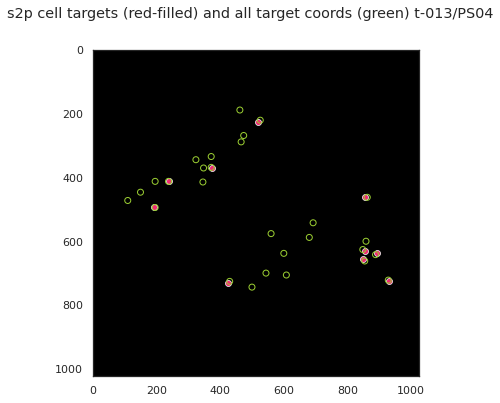

In [3]:
# %% prep for importing data from suite2p for this whole experiment
# determine which frames to retrieve from the overall total s2p output

if not hasattr(expobj, 'suite2p_trials'):
    to_suite2p = ['t-004', 't-006', 't-012', 't-013', 't-014', 't-015', 't-017', 't-018']  # specify all trials that were used in the suite2p run
    baseline_trials = ['t-004', 't-006']  # specify which trials to use as spont baseline
    # note ^^^ this only works currently when the spont baseline trials all come first, and also back to back

    expobj.suite2p_trials = to_suite2p
    expobj.baseline_trials = baseline_trials
    expobj.save()

# main function that imports suite2p data and adds attributes to the expobj
expobj.subset_frames_current_trial(trial=trial, to_suite2p=expobj.suite2p_trials, baseline_trials=expobj.baseline_trials, force_redo=True)
expobj.s2pProcessing(s2p_path=expobj.s2p_path, subset_frames=expobj.curr_trial_frames, subtract_neuropil=True,
                     baseline_frames=expobj.baseline_frames, force_redo=True)
expobj.target_coords_all = expobj.target_coords
expobj.s2p_targets()
aoutils.s2pMaskStack(obj=expobj, pkl_list=[pkl_path], s2p_path=expobj.s2p_path, parent_folder=expobj.analysis_save_path, force_redo=True)



expobj.raw_traces_from_targets(force_redo=True)

plot = False
if plot:
    aoplot.plotSLMtargetsLocs(expobj, background=expobj.meanFluImg)
    aoplot.plotSLMtargetsLocs(expobj, background=expobj.meanFluImg_registered)

### PROCESSING - SLM Targets Flu

- directly analysed, not suite2p ROIs

In [12]:
# collect SLM photostim individual targets -- individual, full traces, dff normalized
expobj.dff_SLMTargets = aoutils.normalize_dff(np.array(expobj.raw_SLMTargets))
expobj.save()

# collect and plot peri- photostim traces for individual SLM target, incl. individual traces for each stim

expobj.pre_stim = int(0.5 * expobj.fps)
expobj.post_stim = int(4 * expobj.fps)
print('Pre-stim frames: ', expobj.pre_stim, ', Post-stim frames: ', expobj.post_stim)
expobj.SLMTargets_stims_dff, expobj.SLMTargets_stims_dffAvg, expobj.SLMTargets_stims_dfstdF, \
expobj.SLMTargets_stims_dfstdF_avg, expobj.SLMTargets_stims_raw, expobj.SLMTargets_stims_rawAvg = \
    expobj.get_alltargets_stim_traces_norm(pre_stim=expobj.pre_stim, post_stim=expobj.post_stim)


# %% photostim. SUCCESS RATE MEASUREMENTS and PLOT - SLM PHOTOSTIM TARGETED CELLS
# measure, for each cell, the pct of trials in which the dFF > 20% post stim (normalized to pre-stim avgF for the trial and cell)
# can plot this as a bar plot for now showing the distribution of the reliability measurement

SLMtarget_ids = list(range(len(expobj.SLMTargets_stims_dfstdF)))

expobj.StimSuccessRate_SLMtargets, expobj.hits_SLMtargets, expobj.responses_SLMtargets = \
    aoutils.calculate_StimSuccessRate(expobj, cell_ids=SLMtarget_ids, raw_traces_stims=expobj.SLMTargets_stims_raw,
                                      dfstdf_threshold=0.3, pre_stim=expobj.pre_stim, sz_filter=False,
                                      verbose=True, plot=False)

expobj.save()






pkl saved to /home/pshah/mnt/qnap/Analysis/2021-01-09/2021-01-09_t-013/2021-01-09_t-013.pkl

Pre-stim frames:  7 , Post-stim frames:  61
collecting stim traces for cell # 1 out of 28
collecting stim traces for cell # 2 out of 28
collecting stim traces for cell # 3 out of 28
collecting stim traces for cell # 4 out of 28
collecting stim traces for cell # 5 out of 28
collecting stim traces for cell # 6 out of 28
collecting stim traces for cell # 7 out of 28
collecting stim traces for cell # 8 out of 28
collecting stim traces for cell # 9 out of 28
collecting stim traces for cell # 10 out of 28
collecting stim traces for cell # 11 out of 28
collecting stim traces for cell # 12 out of 28
collecting stim traces for cell # 13 out of 28
collecting stim traces for cell # 14 out of 28
collecting stim traces for cell # 15 out of 28
collecting stim traces for cell # 16 out of 28
collecting stim traces for cell # 17 out of 28
collecting stim traces for cell # 18 out of 28
collecting stim traces f

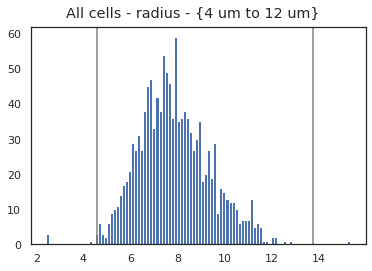

In [5]:
# %% plotting the distribution of radius and aspect ratios - should this be running before the filtering step which is right below????????

radius_list = aoplot.plot_cell_radius_aspectr(expobj, expobj.stat, to_plot='radius')

In [6]:
# %% FILTER ALL CELLS THAT ARE ACTIVE AT LEAST ONCE FOR >2.5*std

# pull out needed variables because numba doesn't work with custom classes (such as this all-optical class object)
cell_ids = expobj.cell_id
raws = expobj.raw
# expobj.append_seizure_frames(bad_frames=None)
photostim_frames = expobj.photostim_frames
radiuses = expobj.radius

# initial quick run to allow numba to compile the function - not sure if this is actually needed/creating time savings
# _, _, _, _ = aoutils._good_cells(cell_ids=cell_ids[:3], raws=raws, photostim_frames=expobj.photostim_frames, radiuses=radiuses,
#                         std_thresh=2, min_radius_pix=2.5, max_radius_pix=8.5)
expobj.good_cells, events_loc_cells, flu_events_cells, stds = aoutils._good_cells(cell_ids=cell_ids, raws=raws, photostim_frames=expobj.photostim_frames, std_thresh=2.5)
expobj.save()

# sort the stds dictionary in order of std
stds_sorted = {}
sorted_keys = sorted(stds, key=stds.get)  # [1, 3, 2]

for w in sorted_keys:
    stds_sorted[w] = stds[w]

# of good cells found:  612  (out of  1259  ROIs)


pkl saved to /home/pshah/mnt/qnap/Analysis/2021-01-09/2021-01-09_t-012/2021-01-09_t-012.pkl



In [7]:
# %% SAVE THE UPDATED expobj OBJECT IN THE ORIGINAL PKL PATH TO USE NEXT

expobj.save_pkl(pkl_path=pkl_path)


print("\n COMPLETED RUNNING ALL OPTICAL PROCESSING PHOTOSTIM.")





pkl saved to /home/pshah/mnt/qnap/Analysis/2021-01-09/2021-01-09_t-012/2021-01-09_t-012.pkl


 COMPLETED RUNNING ALL OPTICAL PROCESSING PHOTOSTIM.


#### processing steps for ALL OPTICAL PHOTOSTIM related stuff

In [8]:
# Collect pre to post stim traces for PHOTOSTIM TARGETED CELLS, FILTER FOR GOOD PHOTOSTIM. TARGETED CELLS with responses above threshold = 1 std of the prestim std

expobj.pre_stim = 1*int(expobj.fps)  # specify pre-stim and post-stim periods of analysis and plotting
expobj.post_stim = 3*int(expobj.fps)

# function for gathering all good photostim cells who respond on average across all trials to the photostim
# note that the threshold for this is 1 * std of the prestim raw flu (fluorescence trace)
expobj.targets_dff, expobj.targets_dff_avg, expobj.targets_dfstdF, \
expobj.targets_dfstdF_avg, expobj.targets_stims_raw, expobj.targets_stims_raw_avg = \
    aoutils.get_s2ptargets_stim_traces(expobj=expobj, normalize_to='pre-stim', pre_stim=expobj.pre_stim,
                                       post_stim=expobj.post_stim)

aoutils._good_photostim_cells(expobj=expobj, pre_stim=expobj.pre_stim, post_stim=expobj.post_stim, dff_threshold=None)


Cell #150 - dFF post-stim: 13.702401 (threshold value = 1.5832670211792106)
Cell #188 - dFF post-stim: 7.4780693 (threshold value = 4.281855138142873)
[std threshold of 1 std]
|- 2 cells out of 5 s2p target cells photostim. responses above threshold
|- Total number of good photostim responsive cells found: 2 (out of 5 s2p photostim target cells)


In [9]:
# %% Collect pre to post stim traces for NON-TARGETS

expobj.dff_traces, expobj.dff_traces_avg, expobj.dfstdF_traces, \
    expobj.dfstdF_traces_avg, expobj.raw_traces, expobj.raw_traces_avg = \
    aoutils.get_nontargets_stim_traces_norm(expobj=expobj, normalize_to='pre-stim', pre_stim=expobj.pre_stim,
                                            post_stim=expobj.post_stim)



Completed collecting pre to post stim traces -- normalized to pre-stim stdF -- for 607 cells


In [11]:
#%% turn important cell x time arrays into pandas dataframes

# raw Flu traces of all good cells
columns = [f'{num}' for num in range(expobj.curr_trial_frames[0], expobj.curr_trial_frames[1])]
index = [f'{num}' for num in expobj.good_cells]
idxs = [expobj.cell_id.index(cell) for cell in expobj.good_cells]
expobj.raw_df = pd.DataFrame(expobj.raw[idxs, :], columns=columns, index=index)


# # raw baseline Flu traces of all good cells
# columns = [f'{num}' for num in range(baseline_frames[0], baseline_frames[1])]
# index = [f'{num}' for num in expobj.good_cells]
# idxs = [expobj.cell_id.index(cell) for cell in expobj.good_cells]
# expobj.baseline_raw_df = pd.DataFrame(expobj.baseline_raw[idxs, :], columns=columns, index=index)



In [12]:
# %% calculate dFF responses of all cells to photostimulation trials expobj

# non-targeted cells: calculate response of non-targeted cells in response to photostim. trials
# - make a pandas dataframe that contains the post-stim response of all cells at each stim timepoint
#   give group name 'non_targets' to the non-targetted cells, and the appropriate SLM group number to targetted cells


expobj.dff_responses_all_cells = aoutils.all_cell_responses_dff(expobj, normalize_to='pre-stim')

# calculate the avg response values for all cells across all stims
average_responses = np.mean(expobj.dff_responses_all_cells[expobj.dff_responses_all_cells.columns[1:]], axis=1)
responses = {'cell_id': [], 'group': [], 'Avg. dFF response': []}
for cell in expobj.good_cells:
    if cell in expobj.s2p_cell_targets:
        responses['cell_id'].append(cell)
        responses['group'].append('photostim target')
        responses['Avg. dFF response'].append(average_responses[cell])
    else:
        responses['cell_id'].append(cell)
        responses['group'].append('non-target')
        responses['Avg. dFF response'].append(average_responses[cell])

expobj.average_responses_df = pd.DataFrame(responses)

print('\nThe avg. dF/F responses of photostim targets is: %s' % np.mean(
    expobj.average_responses_df[expobj.average_responses_df.group == 'photostim target'])[1])

Completed gathering dFF responses to photostim for 617 cells
risky cells (with low Flu values to normalize with):  [47, 51, 78, 94, 111, 171, 187, 198, 227, 237, 280, 298, 303, 354, 429, 431, 465, 491, 500, 502, 543, 544, 554, 560, 578, 642, 650, 669, 731, 763, 792, 811, 861, 866, 882, 892, 909, 1008, 1014, 1064, 1084, 1087, 1122, 1130, 1132, 1152, 1201, 1224, 1236, 1239, 1251, 1299, 1312, 1440, 1551, 1596, 1611, 1614, 1633, 1653, 1654, 1672, 1674, 1715, 1785, 1821, 1887, 1924, 1981, 1982, 2044, 2069, 2082, 2158, 2160, 2368, 2378, 2396, 2425, 2477]

The avg. dF/F responses of photostim targets is: 1.9871934000651046


In [13]:
# %% calculate dF_stdF responses of all cells to photostimulation trials expobj

expobj.dfstdf_all_cells = aoutils.all_cell_responses_dFstdF(expobj)

# calculate the avg response values for all cells across all stims
average_responses_dfstdf = np.mean(expobj.dfstdf_all_cells[expobj.dfstdf_all_cells.columns[1:]], axis=1)
responses = {'cell_id': [], 'group': [], 'Avg. dF/stdF response': []}
for cell in expobj.good_cells:
    if cell in expobj.s2p_cell_targets:
        responses['cell_id'].append(cell)
        responses['group'].append('photostim target')
        responses['Avg. dF/stdF response'].append(average_responses_dfstdf[cell])
    else:
        responses['cell_id'].append(cell)
        responses['group'].append('non-target')
        responses['Avg. dF/stdF response'].append(average_responses_dfstdf[cell])

expobj.average_responses_dfstdf = pd.DataFrame(responses)

print('\nThe avg. dF/stdF responses of photostim targets is: %s' % np.mean(
    expobj.average_responses_dfstdf[expobj.average_responses_dfstdf.group == 'photostim target'])[1])

expobj.save()

Completed gathering dF/stdF responses to photostim for 617 cells

The avg. dF/stdF responses of photostim targets is: 0.318292031288147


pkl saved to /home/pshah/mnt/qnap/Analysis/2021-01-09/2021-01-09_t-012/2021-01-09_t-012.pkl



In [14]:
print('**** END OF PROCESSING ****')



**** END OF PROCESSING ****


SystemExit: 

/home/pshah/anaconda3/envs/2021/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### save results from alloptical processing above

In [15]:
results_object_path = '/home/pshah/mnt/qnap/Analysis/alloptical_results_superobject.pkl'
allOpticalresults = aoutils.import_resultsobj(pkl_path=results_object_path)


importing resultsobj from: /home/pshah/mnt/qnap/Analysis/alloptical_results_superobject.pkl


DONE IMPORT of <class 'alloptical_utils_pj.AllOpticalResults'> resultsobj


In [18]:
mean_reliability_rate = round(np.mean(list(expobj.StimSuccessRate_SLMtargets.values())),2)
mean_response_dfstdf = round(np.mean(list(expobj.responses_SLMtargets)))


In [19]:
prep_trial = '%s %s' % (expobj.metainfo['animal prep.'], expobj.metainfo['trial'])
stim_setup = 
if prep_trial not in list(allOpticalresults.slmtargets_stim_responses['prep_trial']):
    allOpticalresults.slmtargets_stim_responses.loc[allOpticalresults.slmtargets_stim_responses.shape[0]+1] = [prep_trial] + ['-'] * (allOpticalresults.slmtargets_stim_responses.shape[1] - 1)
allOpticalresults.slmtargets_stim_responses.loc[allOpticalresults.slmtargets_stim_responses['prep_trial'] == prep_trial, 'date'] = expobj.metainfo['date']
allOpticalresults.slmtargets_stim_responses.loc[allOpticalresults.slmtargets_stim_responses['prep_trial'] == prep_trial, 'exptype'] = expobj.metainfo['exptype']
allOpticalresults.slmtargets_stim_responses.loc[allOpticalresults.slmtargets_stim_responses['prep_trial'] == prep_trial, 'stim_setup'] = stim_setup
allOpticalresults.slmtargets_stim_responses.loc[allOpticalresults.slmtargets_stim_responses['prep_trial'] == prep_trial, 'mean response (dF/stdF all targets)'] = mean_response_dfstdf
allOpticalresults.slmtargets_stim_responses.loc[allOpticalresults.slmtargets_stim_responses['prep_trial'] == prep_trial, 'mean response (dFF all targets)'] = mean_response_dff
allOpticalresults.slmtargets_stim_responses.loc[allOpticalresults.slmtargets_stim_responses['prep_trial'] == prep_trial, 'mean reliability (>0.3 dF/stdF)'] = mean_reliability_rate


SyntaxError: invalid syntax (<ipython-input-19-b02fc4c148be>, line 2)

In [20]:
expobj.metainfo['animal prep.'] + ' ' + expobj.metainfo['trial']

'PS04 t-013'

In [21]:
[np.mean(i_list) for i_list in expobj.responses_SLMtargets.values()]

[0.07999999999999993,
 -0.47433333333333333,
 -0.2303333333333333,
 0.07699999999999997,
 -0.21566666666666678,
 -0.25900000000000006,
 0.07733333333333331,
 -0.3323333333333333,
 0.404,
 0.29333333333333333,
 0.0036666666666666883,
 0.5116666666666667,
 -0.10233333333333336,
 0.11266666666666666,
 0.36199999999999993,
 0.5533333333333333,
 0.46333333333333326,
 1.0173333333333336,
 -0.5373333333333333,
 -0.9840000000000002,
 0.32266666666666655,
 -0.468,
 -1.0173333333333332,
 -0.025666666666666674,
 -0.105,
 0.11233333333333334,
 0.2106666666666667,
 0.05566666666666663]

In [ ]:
sys.exit()

## alloptical photostim analysis - t-013

trials: ['t-013'] -- pre 4ap all optical

naparm export: 2021-01-09_PS04_020 --'14 cells x 2 groups; 7mW per cell preset: 250ms multi_interleaved 30 trials'

## %% IMPORT MODULES AND TRIAL expobj OBJECT
import sys
sys.path.append('/home/pshah/Documents/code/PackerLab_pycharm/')
sys.path.append('/home/pshah/Documents/code/')
import alloptical_utils_pj as aoutils
import alloptical_plotting_utils as aoplot
import utils.funcs_pj as pj

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage import draw

###### IMPORT pkl file containing data in form of expobj
trial = 't-013'
date = '2021-01-09'

expobj, experiment = aoutils.import_expobj(trial=trial, date=date)

# if not hasattr(expobj, 's2p_path'):
#     expobj.s2p_path = '/home/pshah/mnt/qnap/Analysis/2020-12-18/suite2p/alloptical-2p-1x-alltrials/plane0'

if not hasattr(expobj, 'meanRawFluTrace'):
    expobj.mean_raw_flu_trace(plot=True)

plot = True
if plot:
    aoplot.plotMeanRawFluTrace(expobj=expobj, stim_span_color=None, x_axis='frames', figsize=[20, 3])
    aoplot.plotLfpSignal(expobj, stim_span_color='', x_axis='frames', figsize=[20, 3])
    aoplot.plotSLMtargetsLocs(expobj, background=expobj.meanFluImg_registered)
    aoplot.plot_lfp_stims(expobj)



In [ ]:
# %% plot SLM photostim individual targets -- individual, full traces, dff normalized

# aoplot.plot_photostim_traces(array=expobj.SLMTargets_stims_raw, expobj=expobj, x_label='Frames',
#                                y_label='Raw Flu',
#                                title=(experiment))

expobj.dff_SLMTargets = aoutils.normalize_dff(np.array(expobj.raw_SLMTargets))
expobj.save()

# make rolling average for these plots to smooth out the traces a little more
w = 3
to_plot = np.asarray([(np.convolve(trace, np.ones(w), 'valid') / w) for trace in expobj.dff_SLMTargets])

aoplot.plot_photostim_traces(array=to_plot, expobj=expobj, x_label='Frames',
                             y_label='dFF Flu', title=experiment)

aoplot.plot_photostim_traces_overlap(array=expobj.dff_SLMTargets, expobj=expobj, x_axis='Time (secs.)',
                                     title='%s - dFF Flu photostims' % experiment, figsize=(2*20, 2*len(to_plot)*0.15))



In [ ]:
expobj.pre_stim = int(0.5 * expobj.fps)
expobj.post_stim = int(4 * expobj.fps)
expobj.SLMTargets_stims_dff, expobj.SLMTargets_stims_dffAvg, expobj.SLMTargets_stims_dfstdF, \
expobj.SLMTargets_stims_dfstdF_avg, expobj.SLMTargets_stims_raw, expobj.SLMTargets_stims_rawAvg = \
    expobj.get_alltargets_stim_traces_norm(pre_stim=expobj.pre_stim, post_stim=expobj.post_stim)


x = np.asarray([i for i in expobj.SLMTargets_stims_dfstdF_avg])

y_label = 'dF/prestim_stdF'
aoplot.plot_periphotostim_avg(arr=expobj.SLMTargets_stims_dfstdF_avg, expobj=expobj, stim_duration=expobj.stim_duration_frames,
                              figsize=[5, 4], y_lims=[-0.5, 3],
                              title=(experiment + '- responses of all photostim targets'),
                              y_label=y_label, x_label='Time post-stimulation (seconds)')


collecting stim traces for cell  1


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


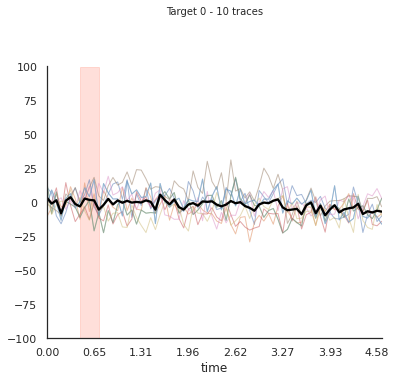

collecting stim traces for cell  2


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


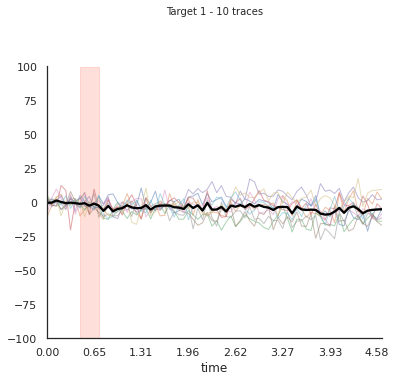

collecting stim traces for cell  3


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


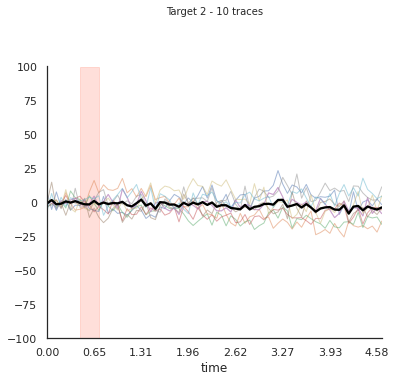

collecting stim traces for cell  4


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


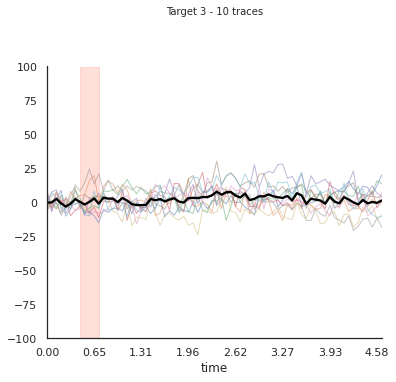

collecting stim traces for cell  5


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


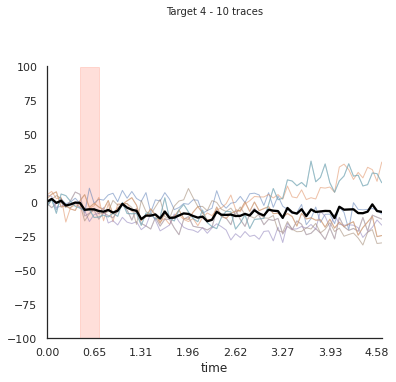

collecting stim traces for cell  6


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


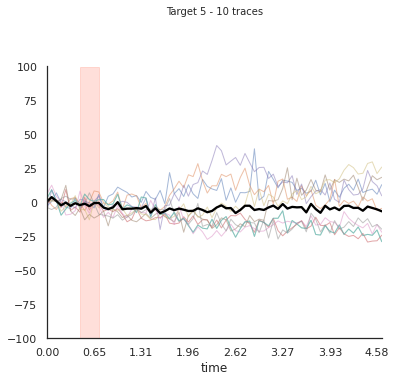

collecting stim traces for cell  7


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


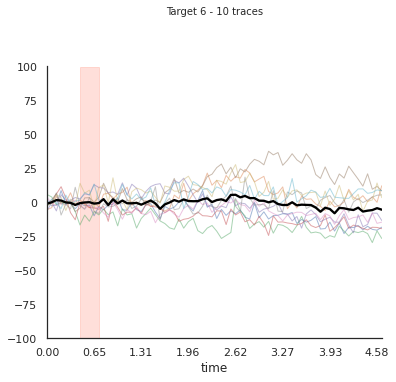

collecting stim traces for cell  8


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


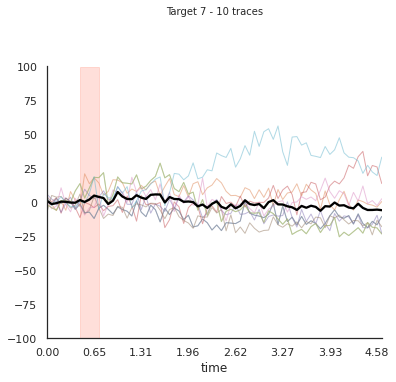

collecting stim traces for cell  9


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


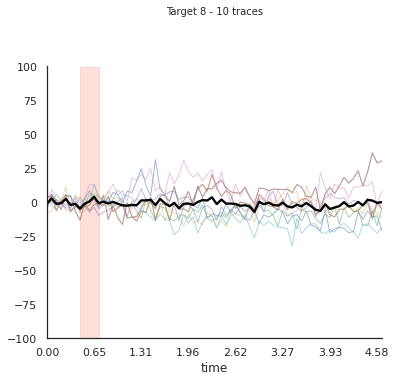

collecting stim traces for cell  10


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


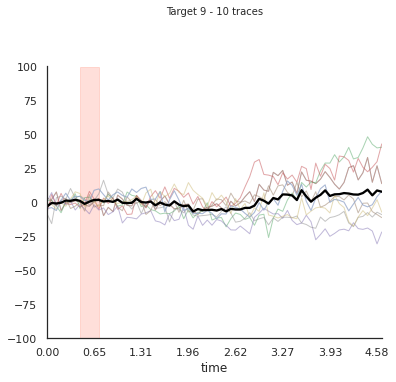

collecting stim traces for cell  11


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


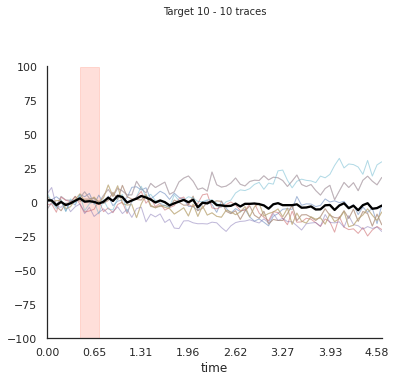

collecting stim traces for cell  12


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


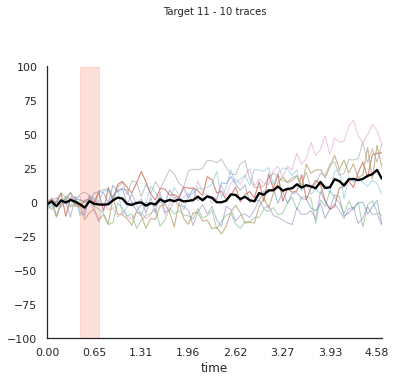

collecting stim traces for cell  13


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


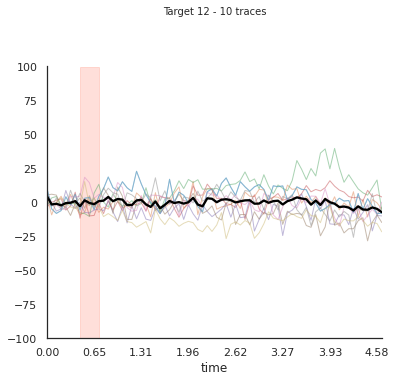

collecting stim traces for cell  14


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


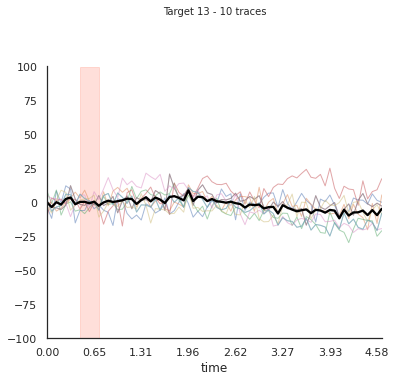

collecting stim traces for cell  15


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


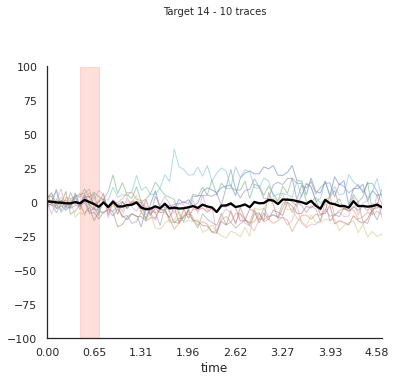

/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


collecting stim traces for cell  16


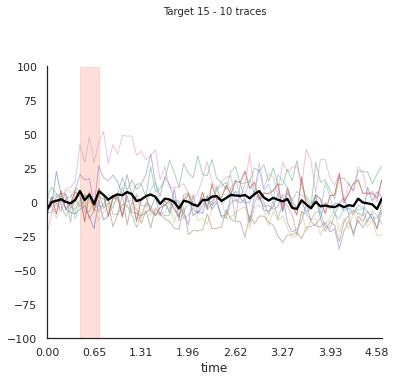

collecting stim traces for cell  17


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


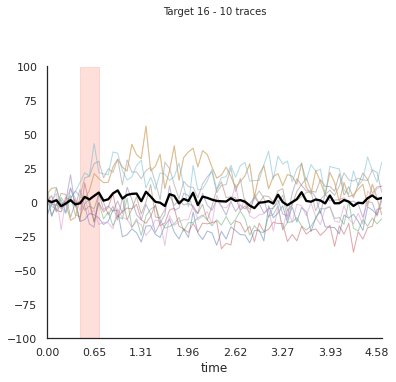

collecting stim traces for cell  18


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


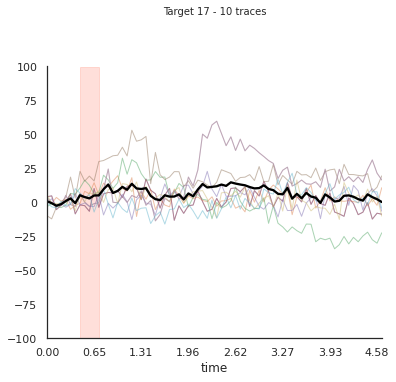

collecting stim traces for cell  19


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


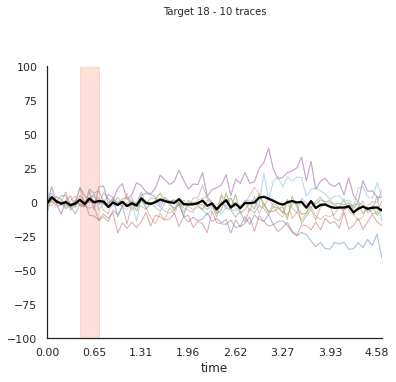

collecting stim traces for cell  20


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


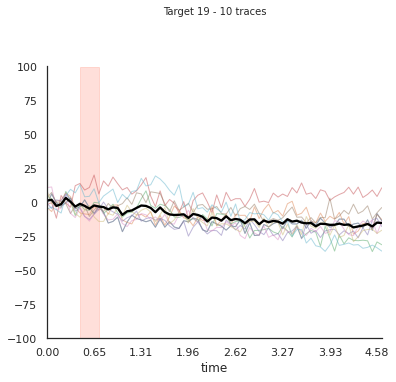

collecting stim traces for cell  21


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


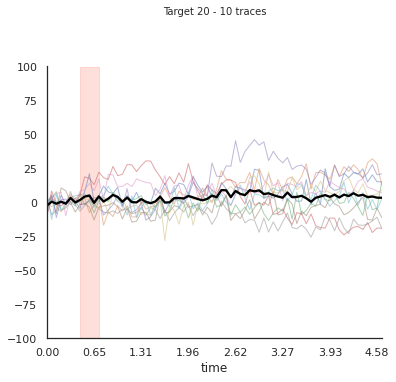

collecting stim traces for cell  22


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


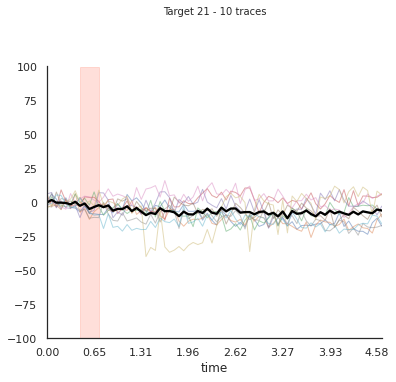

collecting stim traces for cell  23


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


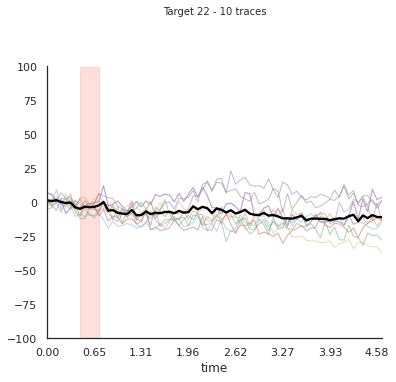

collecting stim traces for cell  24


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


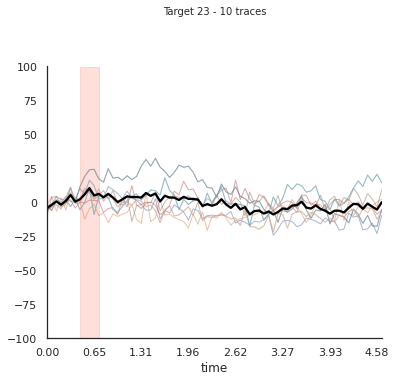

collecting stim traces for cell  25


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


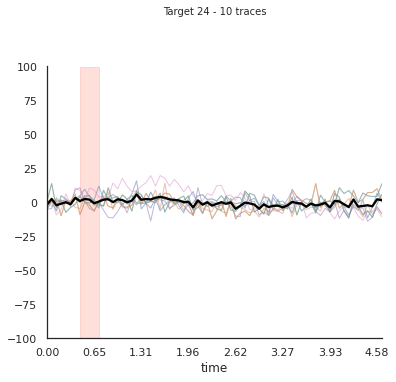

collecting stim traces for cell  26


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


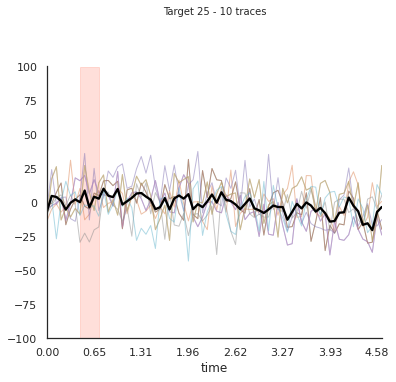

collecting stim traces for cell  27


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


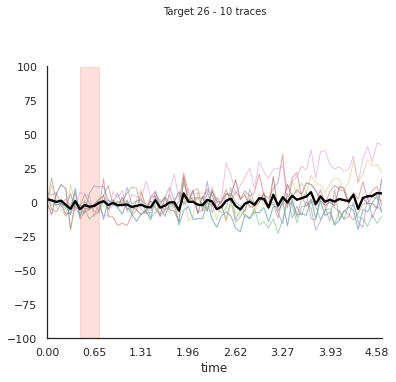

collecting stim traces for cell  28


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting_utils.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_format.format(x) for x in labels])


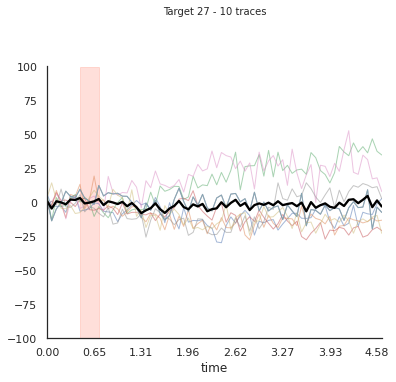

In [22]:
plot = True
for i in range(0, expobj.n_targets_total):
    SLMTargets_stims_raw, SLMTargets_stims_dff, SLMtargets_stims_dfstdF = expobj.get_alltargets_stim_traces_norm(targets_idx=i, pre_stim=expobj.pre_stim,
                                                                                                                 post_stim=expobj.post_stim)
    if plot:
#         w = 2
#         array = [(np.convolve(trace, np.ones(w), 'valid') / w) for trace in SLMTargets_stims_raw]
        random_sub = np.random.randint(0,30,10)
        aoplot.plot_periphotostim_avg(arr=SLMTargets_stims_dff[random_sub], expobj=expobj, stim_duration=expobj.stim_duration_frames, x_label = 'time',
                                      title='Target ' + str(i), pre_stim=expobj.pre_stim, post_stim=expobj.post_stim, color='steelblue', y_lims=[-100, 100],
                                     figsize=[6,5])